# 프로젝트 개요

- 개요 : 마케팅-관리를 위해 고객의 '연체 위험도'를 예측하는 머신러닝 모델 구현 <br>
- 데이터 : 2만6천여명 고객의 성별, 부동산, 자동차, 가족, 등록기간 등의 정보 <br>
- 보고서 : https://docs.google.com/presentation/d/1fRNDxStAOMcYUGpH7WREeybG3wci0K81eMdNQrOQ09I/edit?usp=sharing


# Library

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# EDA
from sklearn.model_selection import train_test_split

# Preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from category_encoders import OneHotEncoder, OrdinalEncoder

# Model
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Score
from sklearn.metrics import accuracy_score, classification_report, recall_score, precision_score, f1_score

# Class Imbalance
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

# Tuning
from sklearn.model_selection import RandomizedSearchCV

# Model Interpretation
import eli5
from eli5.sklearn import PermutationImportance
from pdpbox.pdp import pdp_isolate, pdp_plot

ModuleNotFoundError: No module named 'pandas'

In [2]:
# 소수점 4자리까지 보이도록 설정
pd.set_option('display.float_format', '{:,.4f}'.format)

# EDA

## 데이터 불러오기

In [4]:
df = pd.read_csv('bank.csv')
df

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,"202,500.0000",Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0000,-6.0000,1.0000
1,1,F,N,Y,1,"247,500.0000",Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0000,-5.0000,1.0000
2,2,M,Y,Y,0,"450,000.0000",Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0000,-22.0000,2.0000
3,3,F,N,Y,0,"202,500.0000",Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0000,-37.0000,0.0000
4,4,F,Y,Y,0,"157,500.0000",State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0000,-26.0000,2.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,26452,F,N,N,2,"225,000.0000",State servant,Secondary / secondary special,Married,House / apartment,-12079,-1984,1,0,0,0,Core staff,4.0000,-2.0000,1.0000
26453,26453,F,N,Y,1,"180,000.0000",Working,Higher education,Separated,House / apartment,-15291,-2475,1,0,0,0,NaN,2.0000,-47.0000,2.0000
26454,26454,F,Y,N,0,"292,500.0000",Working,Secondary / secondary special,Civil marriage,With parents,-10082,-2015,1,0,0,0,Core staff,2.0000,-25.0000,2.0000
26455,26455,M,N,Y,0,"171,000.0000",Working,Incomplete higher,Single / not married,House / apartment,-10145,-107,1,0,0,0,Laborers,1.0000,-59.0000,2.0000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          26457 non-null  int64  
 1   gender         26457 non-null  object 
 2   car            26457 non-null  object 
 3   reality        26457 non-null  object 
 4   child_num      26457 non-null  int64  
 5   income_total   26457 non-null  float64
 6   income_type    26457 non-null  object 
 7   edu_type       26457 non-null  object 
 8   family_type    26457 non-null  object 
 9   house_type     26457 non-null  object 
 10  DAYS_BIRTH     26457 non-null  int64  
 11  DAYS_EMPLOYED  26457 non-null  int64  
 12  FLAG_MOBIL     26457 non-null  int64  
 13  work_phone     26457 non-null  int64  
 14  phone          26457 non-null  int64  
 15  email          26457 non-null  int64  
 16  occyp_type     18286 non-null  object 
 17  family_size    26457 non-null  float64
 18  begin_

## 결측치-중복치 처리

In [6]:
# 컬럼별 결측치수 확인
df.isnull().sum()

# occyp_type의 결측치 수가 전체 데이터의 1/3 수준. 아래 feature engineering에서 해당 컬럼 삭제

index               0
gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       8171
family_size         0
begin_month         0
credit              0
dtype: int64

In [7]:
# 중복된 데이터수 확인
df.duplicated().sum()

0

In [8]:
# 중복치 삭제 및 확인
df.drop_duplicates(inplace=True)

# 처리 결과 확인
duplicate_result = df.duplicated().sum()

if duplicate_result.sum() == 0:
  print("중복치가 모두 처리되었습니다")
else :
  print("중복치를 다시 확인하세요")

중복치가 모두 처리되었습니다


In [9]:
# index reset
df.reset_index(drop=True, inplace=True)
df.shape

(26457, 20)

## 데이터 파악

In [10]:
# 카디널리티 확인
df.nunique()

index            26457
gender               2
car                  2
reality              2
child_num            9
income_total       249
income_type          5
edu_type             5
family_type          5
house_type           6
DAYS_BIRTH        6621
DAYS_EMPLOYED     3470
FLAG_MOBIL           1
work_phone           2
phone                2
email                2
occyp_type          18
family_size         10
begin_month         61
credit               3
dtype: int64

In [11]:
# 범주형 변수값 확인

object_cols = ['income_type', 'edu_type', 'family_type', 'house_type']

for col in object_cols:
    print(f'col name : {col}')
    print(df[col].value_counts(normalize=True))
    print("--------------")

col name : income_type
Working                0.5157
Commercial associate   0.2344
Pensioner              0.1682
State servant          0.0814
Student                0.0003
Name: income_type, dtype: float64
--------------
col name : edu_type
Secondary / secondary special   0.6802
Higher education                0.2707
Incomplete higher               0.0386
Lower secondary                 0.0097
Academic degree                 0.0009
Name: edu_type, dtype: float64
--------------
col name : family_type
Married                0.6878
Single / not married   0.1321
Civil marriage         0.0802
Separated              0.0582
Widow                  0.0417
Name: family_type, dtype: float64
--------------
col name : house_type
House / apartment     0.8940
With parents          0.0475
Municipal apartment   0.0309
Rented apartment      0.0162
Office apartment      0.0072
Co-op apartment       0.0042
Name: house_type, dtype: float64
--------------


## 특성 공학

In [13]:
def eda(df):    
    
    df_eda = df.copy()
    
    # 나이, 근속기간, 등록기간 컬럼 : 날짜 기준에서 연도 기준으로 변환
    df_eda['age'] = df['DAYS_BIRTH'] * -1 // 365
    df_eda['employed'] = df['DAYS_EMPLOYED'] * -1 // 365
    df_eda['registered_month'] = df['begin_month'] * -1
    
    # 핸드폰, 이메일, 업무 전화 컬럼 : 연락수단 갯수 컬럼으로 합치기
    df_eda['contact_method'] = df['work_phone'] + df['phone'] + df['email']
    
    # 필요없는 컬럼 삭제
    remove_cols = ['index','occyp_type', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_MOBIL', 'work_phone', 'phone', 'email', 'begin_month']
    df_eda.drop(columns=remove_cols, inplace=True)

    # 부동산-자동차 소유 여부 컬럼 : 0과 1로 변환
    yesno_map = {'N':0, 'Y':1}
    df_eda['car'] = df_eda['car'].map(yesno_map)
    df_eda['reality'] = df_eda['reality'].map(yesno_map)

    # 데이터타입 변경
    df_eda['income_total'] = df_eda['income_total'].astype('int')
    df_eda['family_size'] = df_eda['family_size'].astype('int')
    df_eda['credit'] = df_eda['credit'].astype('int')
    df_eda['registered_month'] = df_eda['registered_month'].astype('int')
    
    print(df_eda.info())
    return df_eda

df_eda = eda(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   gender            26457 non-null  object
 1   car               26457 non-null  int64 
 2   reality           26457 non-null  int64 
 3   child_num         26457 non-null  int64 
 4   income_total      26457 non-null  int32 
 5   income_type       26457 non-null  object
 6   edu_type          26457 non-null  object
 7   family_type       26457 non-null  object
 8   house_type        26457 non-null  object
 9   family_size       26457 non-null  int32 
 10  credit            26457 non-null  int32 
 11  age               26457 non-null  int64 
 12  employed          26457 non-null  int64 
 13  registered_month  26457 non-null  int32 
 14  contact_method    26457 non-null  int64 
dtypes: int32(4), int64(6), object(5)
memory usage: 2.6+ MB
None


In [14]:
# 확인
df_eda

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,family_size,credit,age,employed,registered_month,contact_method
0,F,0,0,0,202500,Commercial associate,Higher education,Married,Municipal apartment,2,1,38,12,6,0
1,F,0,1,1,247500,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,3,1,31,4,5,1
2,M,1,1,0,450000,Working,Higher education,Married,House / apartment,2,2,52,12,22,1
3,F,0,1,0,202500,Commercial associate,Secondary / secondary special,Married,House / apartment,2,0,41,5,37,1
4,F,1,1,0,157500,State servant,Higher education,Married,House / apartment,2,2,41,5,26,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,F,0,0,2,225000,State servant,Secondary / secondary special,Married,House / apartment,4,1,33,5,2,0
26453,F,0,1,1,180000,Working,Higher education,Separated,House / apartment,2,2,41,6,47,0
26454,F,1,0,0,292500,Working,Secondary / secondary special,Civil marriage,With parents,2,2,27,5,25,0
26455,M,0,1,0,171000,Working,Incomplete higher,Single / not married,House / apartment,1,2,27,0,59,0


## 이상치 처리

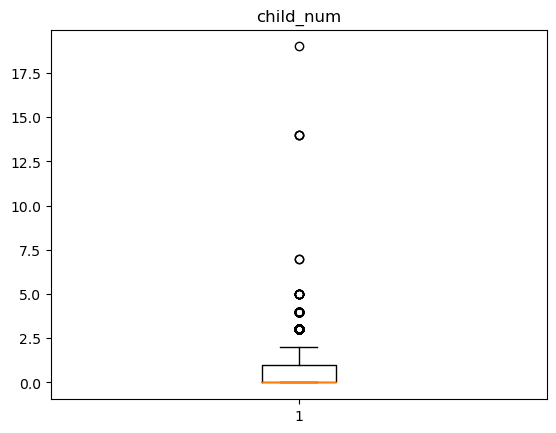

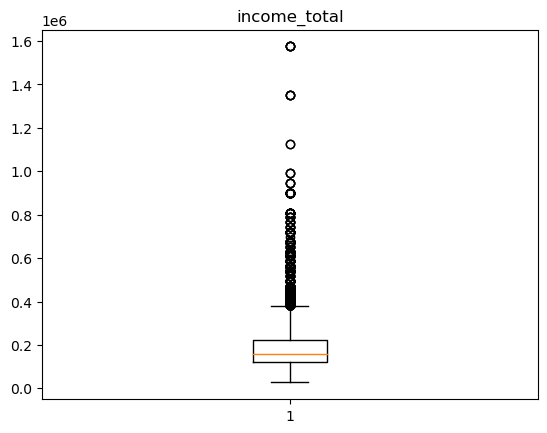

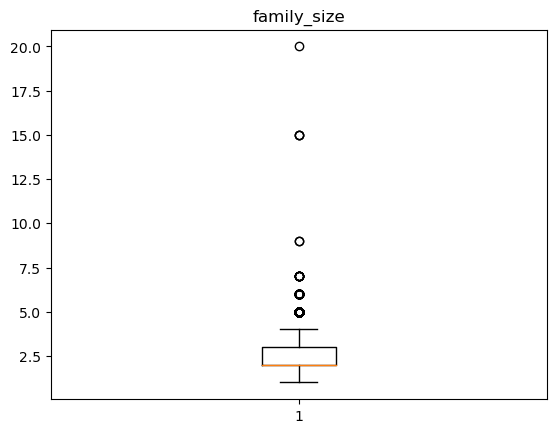

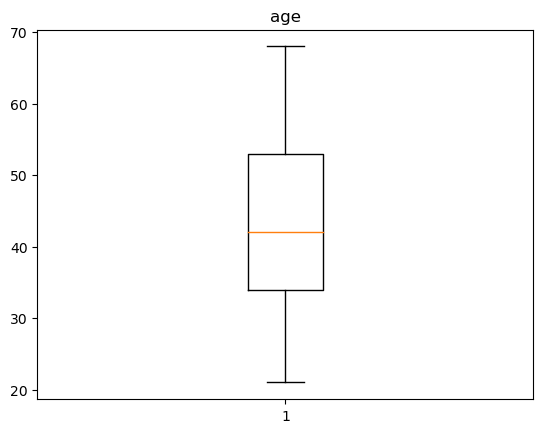

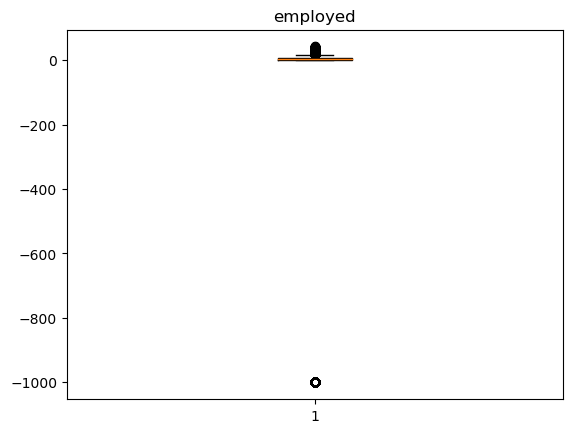

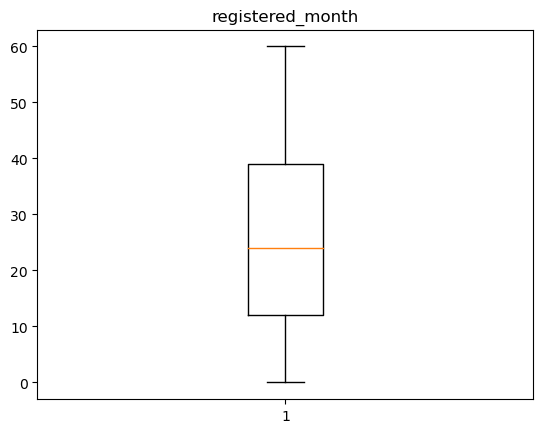

In [15]:
# 분포 확인

outlier_check = ['child_num', 'income_total', 'family_size', 'age', 'employed', 'registered_month']

for i, col in zip(range(len(outlier_check)), outlier_check):
    plt.figure(i)
    plt.boxplot(df_eda[col])
    plt.title(col)
    plt.show

In [16]:
# 자녀수 컬럼 이상치 삭제
df_eda.drop(df_eda[df_eda['child_num'] > 12].index, axis=0, inplace=True)

In [17]:
# 근속연수 컬럼 이상치 확인
df_eda[df_eda['employed'] < 0]

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,family_size,credit,age,employed,registered_month,contact_method
14,F,0,1,0,157500,Pensioner,Secondary / secondary special,Single / not married,House / apartment,1,2,62,-1001,41,1
18,F,0,1,0,216000,Pensioner,Secondary / secondary special,Married,House / apartment,2,2,63,-1001,37,0
21,F,0,0,0,157500,Pensioner,Secondary / secondary special,Married,House / apartment,2,2,58,-1001,7,1
24,F,0,0,0,202500,Pensioner,Secondary / secondary special,Single / not married,House / apartment,1,2,61,-1001,5,1
46,F,0,0,0,135000,Pensioner,Secondary / secondary special,Widow,House / apartment,1,2,57,-1001,24,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26431,F,0,1,0,225000,Pensioner,Secondary / secondary special,Widow,House / apartment,1,1,57,-1001,60,1
26432,F,1,1,0,72000,Pensioner,Secondary / secondary special,Married,House / apartment,2,1,61,-1001,17,1
26439,F,0,1,0,67500,Pensioner,Secondary / secondary special,Married,House / apartment,2,2,52,-1001,57,0
26441,F,0,1,0,90000,Pensioner,Incomplete higher,Separated,House / apartment,1,2,66,-1001,43,0


In [18]:
# 근속연수가 -1001로 계산된 경우가 4000여건
df_eda['employed'].value_counts() 

-1001    4438
 1       2340
 3       2075
 4       2046
 2       2038
 0       1870
 5       1540
 6       1510
 8       1332
 7       1139
 9        954
 10       783
 12       563
 11       517
 14       432
 15       425
 13       417
 18       223
 20       214
 16       190
 19       185
 17       170
 21       133
 22       130
 25       121
 23       112
 24        83
 27        78
 26        67
 29        65
 28        40
 32        36
 31        34
 30        25
 33        24
 35        23
 34        18
 41        17
 39        13
 40        12
 36        10
 38         6
 37         2
 42         2
 43         1
Name: employed, dtype: int64

In [19]:
# age가 비슷한 사람의 employed값으로 대체

# 데이터셋 카피 후 age 기준으로 sort
df_copy = df_eda.copy().sort_values('age')

# 이상치를 nan값으로 대체
employed_list = []
for idx, row in df_copy.iterrows():
    if row['employed'] == -1001:
        employed_list.append(np.NaN)
    else:
        employed_list.append(row['employed'])
        
df_copy['employed'] = employed_list

# ffill로 결측치 메우기
df_copy.fillna(method='ffill', inplace=True)
print(f'employed 컬럼 결측치 : {df_copy.employed.isnull().sum()}')

# 컬럼 데이터타입 변경
df_copy['employed'] = df_copy['employed'].astype('int')

# index 기준으로 sort 되돌리기
df_eda = df_copy.sort_index()
df_eda.employed.value_counts()

employed 컬럼 결측치 : 0


1     2628
3     2344
4     2342
2     2261
0     2189
5     2030
6     1721
8     1519
7     1305
9     1192
10     935
11     701
12     678
14     636
15     533
13     503
20     287
18     279
16     252
21     230
19     223
23     190
17     188
22     149
25     149
24     112
26     106
29      99
27      97
31      66
36      62
41      60
32      56
28      54
35      50
39      48
40      46
34      37
30      32
33      31
38      14
42      13
43       4
37       2
Name: employed, dtype: int64

In [20]:
# index reset
df_eda.reset_index(drop=True, inplace=True)
df_eda.shape

(26453, 15)

# Analysis

<Figure size 640x480 with 0 Axes>

<Figure size 3000x1200 with 0 Axes>

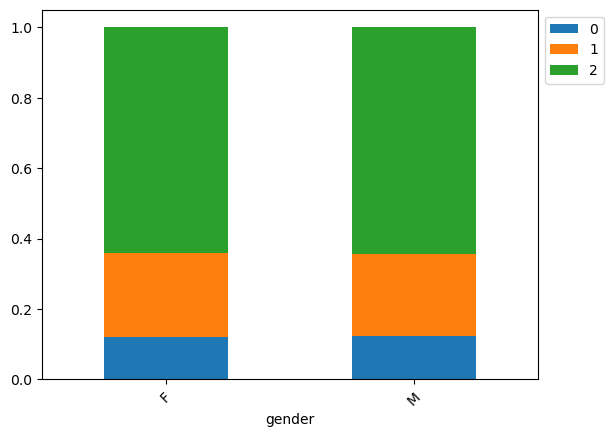

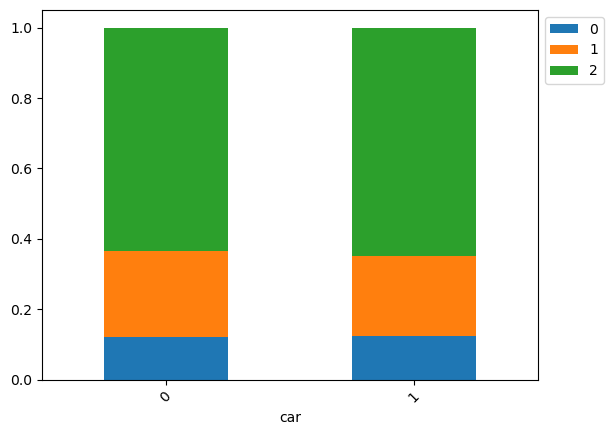

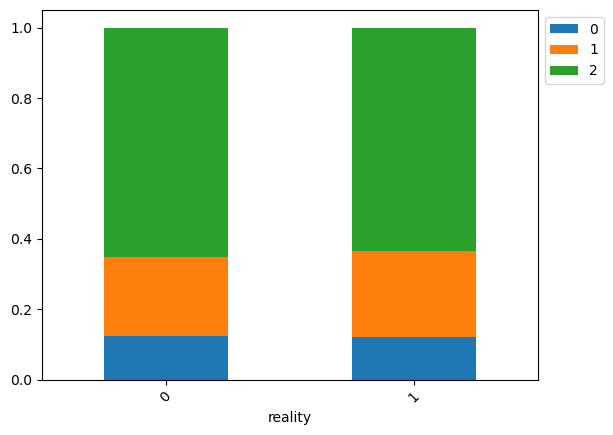

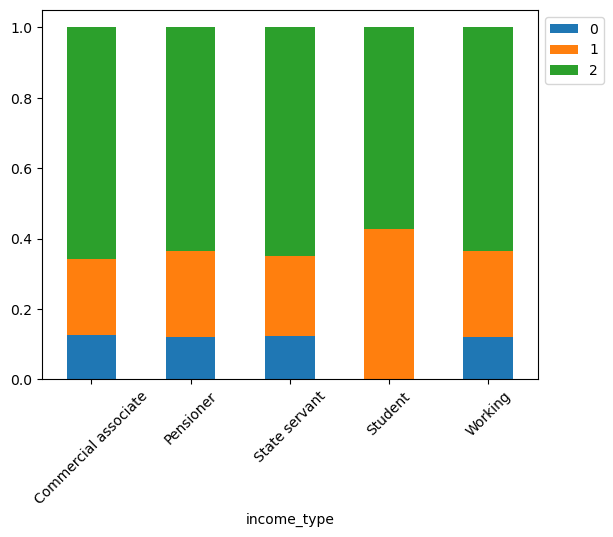

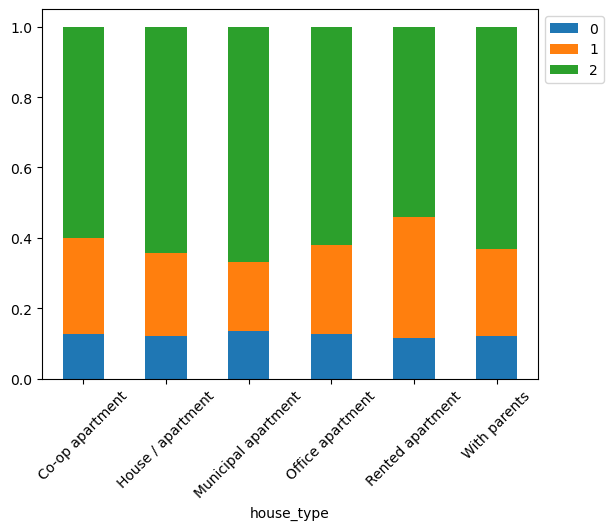

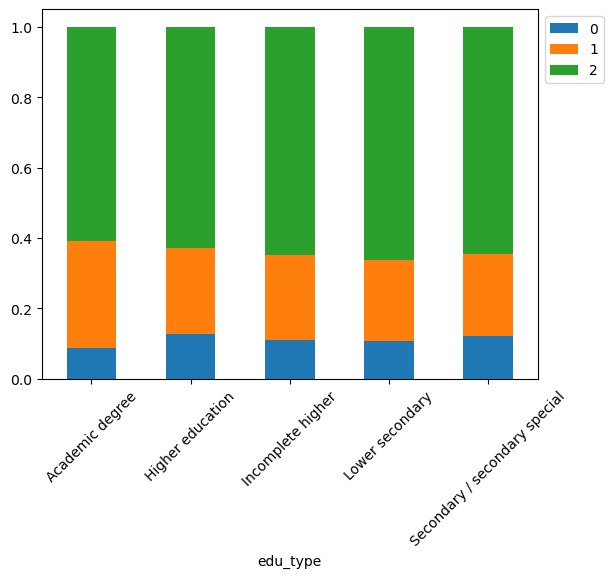

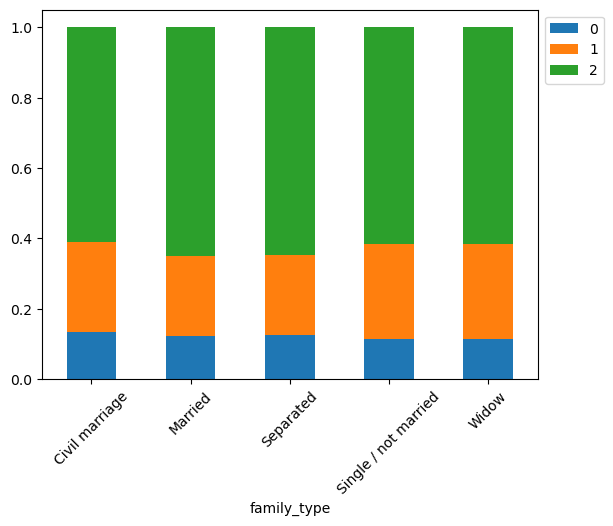

In [22]:
# 범주형 컬럼별로 타겟 비중 분석
target = 'credit'

obj_cols = ['gender', 'car', 'reality', 'income_type', 'edu_type', 'house_type', 'family_type']
fig = plt.figure(figsize=(30, 12))

for i, feature in enumerate(obj_cols) :
    plt.figure(i)
    tmp = pd.crosstab(index=df_eda[feature], columns=df_eda[target], normalize='index')
    tmp.plot(kind='bar', stacked=True)
    plt.xticks(rotation=45)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    i += 1
plt.show()

In [23]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26453 entries, 0 to 26452
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   gender            26453 non-null  object
 1   car               26453 non-null  int64 
 2   reality           26453 non-null  int64 
 3   child_num         26453 non-null  int64 
 4   income_total      26453 non-null  int32 
 5   income_type       26453 non-null  object
 6   edu_type          26453 non-null  object
 7   family_type       26453 non-null  object
 8   house_type        26453 non-null  object
 9   family_size       26453 non-null  int32 
 10  credit            26453 non-null  int32 
 11  age               26453 non-null  int64 
 12  employed          26453 non-null  int32 
 13  registered_month  26453 non-null  int32 
 14  contact_method    26453 non-null  int64 
dtypes: int32(5), int64(5), object(5)
memory usage: 2.5+ MB


In [24]:
df_eda.groupby(target).mean()

,car,reality,child_num,income_total,family_size,age,employed,registered_month,contact_method
credit,,,,,,,,,
0,0.3849,0.6698,0.4181,"190,807.5816",2.1943,42.9777,7.2542,23.9879,0.6130
1,0.3633,0.6912,0.4305,"181,122.7008",2.1771,42.6006,6.9853,21.0788,0.5941
2,0.3848,0.6682,0.4265,"188,923.7920",2.2013,43.4846,7.4840,28.3919,0.6158


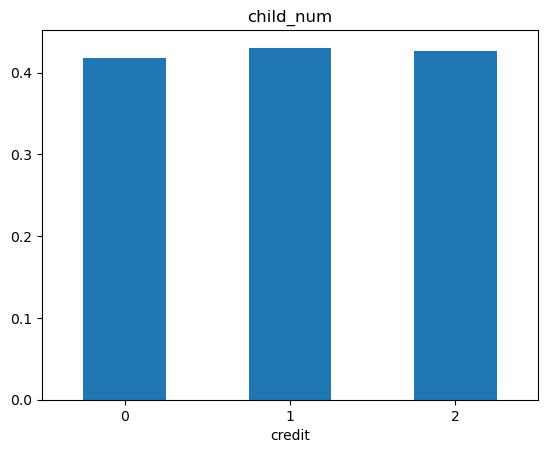

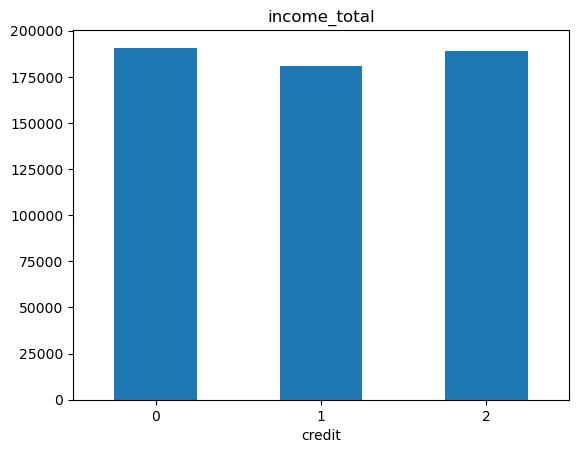

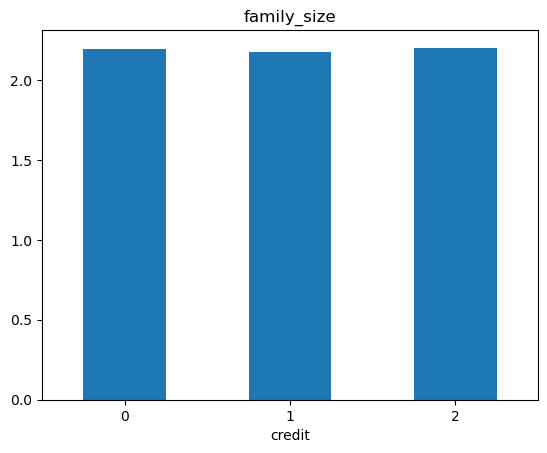

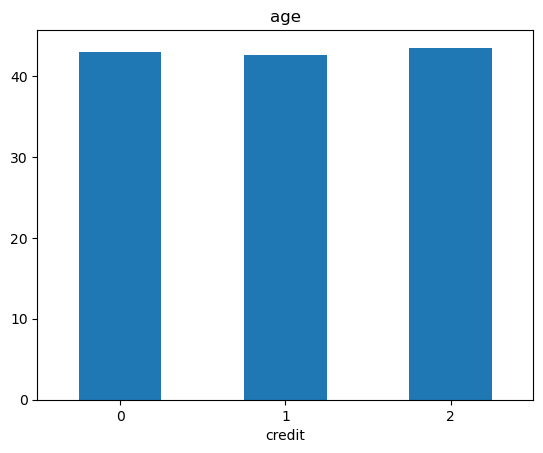

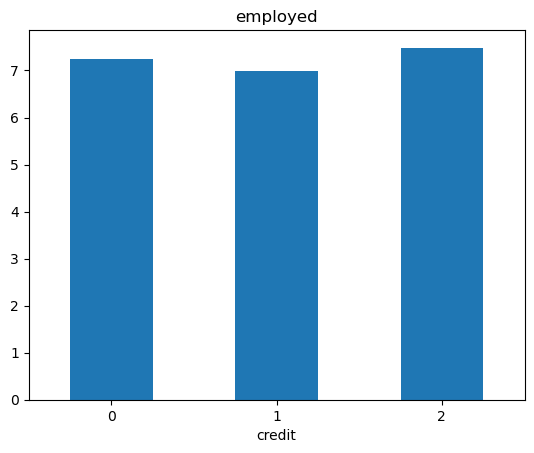

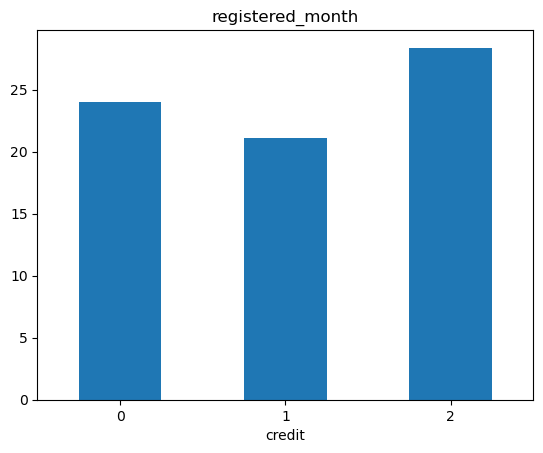

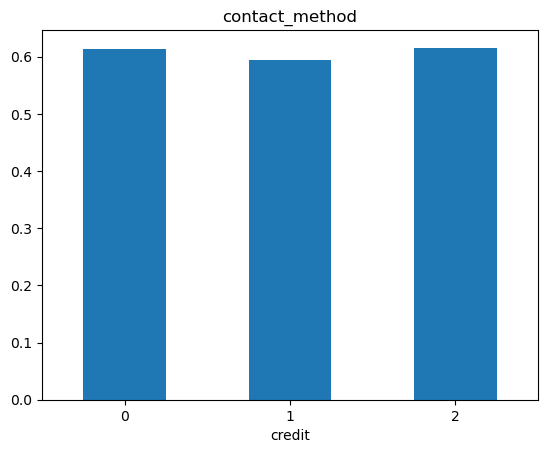

In [25]:
# 수치형 컬럼별로 타겟 분석
num_cols = ['child_num', 'income_total', 'family_size', 'age', 'employed', 'registered_month', 'contact_method']

i = 1
for col in num_cols:
    plt.figure(i)
    table = df_eda.groupby(target).mean()[col]
    table.plot(kind='bar', stacked=True)
    plt.title(col)
    plt.xticks(rotation=0)
    i += 1

# Modeling

## 전처리

### 데이터셋 분리 (train / val / test)

In [26]:
# target / feature 분리

target = 'credit'
x = df_eda.drop(target, axis=1)
y = df_eda[target]

print(f'x shape : {x.shape}')
print(f'y shape : {y.shape}')

x shape : (26453, 14)
y shape : (26453,)


In [27]:
## 데이터셋 분리 (train / val / test)# train / val / test 분리

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=1)

print(f'train data : x{x_train.shape}, y{y_train.shape}')
print(f'val data : x{x_val.shape}, y{y_val.shape}')
print(f'test data : x{x_test.shape}, y{y_test.shape}')

train data : x(16929, 14), y(16929,)
val data : x(4233, 14), y(4233,)
test data : x(5291, 14), y(5291,)


### target 비율 확인 

In [28]:
# 타겟은 연체 위험도
y.value_counts(normalize=True)

2   0.6413
1   0.2369
0   0.1218
Name: credit, dtype: float64

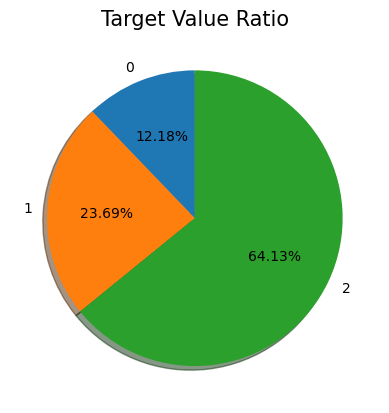

In [29]:
zero_label = y.value_counts(normalize=True)[0]
one_label = y.value_counts(normalize=True)[1]
two_label = y.value_counts(normalize=True)[2]

plt.pie(
    (zero_label, one_label, two_label),
    labels=(0, 1, 2),
    autopct="%.2f%%",
    shadow=True,
    startangle=90,
)
plt.title("Target Value Ratio", size=15)
plt.show()

## Model 선택

In [30]:
def eval_models(y_true, y_pred) :
    accuracy = accuracy_score(y_true, y_pred)
    f1_class0 = f1_score(y_true, y_pred, average=None)[0]
    f1_class1 = f1_score(y_true, y_pred, average=None)[1]
    f1_class2 = f1_score(y_true, y_pred, average=None)[2]
        
    return accuracy, f1_class0, f1_class1, f1_class2

In [31]:
def train_val_score(model):
    y_train_pred = model.predict(x_train)
    y_val_pred = model.predict(x_val)

    model_eval = pd.DataFrame(index=['Accuracy', 'F1_class0', 'F1_class1', 'F1_class2'], columns=['Train', 'Val'])
    model_eval['Train'] = eval_models(y_train, y_train_pred)
    model_eval['Val'] = eval_models(y_val, y_val_pred)
    
    display(model_eval)
    return model_eval

In [32]:
# 기준모델
base = y_train.mode()[0]
baseline = [base] * len(y_train)

# 평가
acc, f0, f1, f2 = eval_models(y_train, baseline)
print(f"accuracy : {acc}")
print(f'f1 score : class0 - {f0}, class1 - {f1}, class2 - {f2}')

# 모델별 score
eval_table = pd.DataFrame(index=['Accuracy', 'F1_class0', 'F1_class1', 'F1_class2'], 
                          columns=['Baseline', 'Logistic', 'KNN', 'naivebayes', 'DecisionTree', 'RandomForest', 'XGB'])
eval_table['Baseline'] = eval_models(y_train, baseline)
eval_table

accuracy : 0.6398487801996574
f1 score : class0 - 0.0, class1 - 0.0, class2 - 0.7803753467094124


,Baseline,Logistic,KNN,naivebayes,DecisionTree,RandomForest,XGB
Accuracy,0.6398,NaN,NaN,NaN,NaN,NaN,NaN
F1_class0,0.0000,NaN,NaN,NaN,NaN,NaN,NaN
F1_class1,0.0000,NaN,NaN,NaN,NaN,NaN,NaN
F1_class2,0.7804,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
# LogisticRegression

logistic = make_pipeline(
    OneHotEncoder(),
    StandardScaler(),
    LogisticRegression(random_state = 1))

logistic.fit(x_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['gender', 'income_type', 'edu_type',
                                     'family_type', 'house_type'])),
                ('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(random_state=1))])

In [34]:
# train-val score
train_val_score(logistic)

# 모델별 score
y_val_pred = logistic.predict(x_val)
eval_table['Logistic'] = eval_models(y_val, y_val_pred)
eval_table

,Train,Val
Accuracy,0.6411,0.6480
F1_class0,0.0000,0.0000
F1_class1,0.0179,0.0244
F1_class2,0.7812,0.7860


,Baseline,Logistic,KNN,naivebayes,DecisionTree,RandomForest,XGB
Accuracy,0.6398,0.6480,NaN,NaN,NaN,NaN,NaN
F1_class0,0.0000,0.0000,NaN,NaN,NaN,NaN,NaN
F1_class1,0.0000,0.0244,NaN,NaN,NaN,NaN,NaN
F1_class2,0.7804,0.7860,NaN,NaN,NaN,NaN,NaN


In [35]:
# KNN

knn = make_pipeline(
    OrdinalEncoder(),
    StandardScaler(),
    KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2))

knn.fit(x_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['gender', 'income_type', 'edu_type',
                                      'family_type', 'house_type'],
                                mapping=[{'col': 'gender',
                                          'data_type': dtype('O'),
                                          'mapping': F      1
M      2
NaN   -2
dtype: int64},
                                         {'col': 'income_type',
                                          'data_type': dtype('O'),
                                          'mapping': Commercial associate    1
Working                 2
Pensioner               3
State servant           4
Student                 5
NaN                    -2
dtype: int64},
                                         {'col': 'edu_type',
                                          'dat...
                                          'data_type': dtype('O'),
                                          'mapping': Civil marriage          1
Married                 2
Separated               3
Single / not married    4
Widow                   5
NaN                    -2
dtype: int64},
                                         {'col': 'house_type',
                                          'data_type': dtype('O'),
                                          'mapping': House / apartment      1
Rented apartment       2
With parents           3
Municipal apartment    4
Office apartment       5
Co-op apartment        6
NaN                   -2
dtype: int64}])),
                ('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [36]:
# train-val score
train_val_score(knn)

# 모델별 score
y_val_pred = knn.predict(x_val)
eval_table['KNN'] = eval_models(y_val, y_val_pred)
eval_table

,Train,Val
Accuracy,0.7355,0.6123
F1_class0,0.4555,0.2361
F1_class1,0.5709,0.3512
F1_class2,0.8318,0.7477


,Baseline,Logistic,KNN,naivebayes,DecisionTree,RandomForest,XGB
Accuracy,0.6398,0.6480,0.6123,NaN,NaN,NaN,NaN
F1_class0,0.0000,0.0000,0.2361,NaN,NaN,NaN,NaN
F1_class1,0.0000,0.0244,0.3512,NaN,NaN,NaN,NaN
F1_class2,0.7804,0.7860,0.7477,NaN,NaN,NaN,NaN


In [37]:
# naivebayes

nb = make_pipeline(
    OrdinalEncoder(),
    StandardScaler(),
    GaussianNB())

nb.fit(x_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['gender', 'income_type', 'edu_type',
                                      'family_type', 'house_type'],
                                mapping=[{'col': 'gender',
                                          'data_type': dtype('O'),
                                          'mapping': F      1
M      2
NaN   -2
dtype: int64},
                                         {'col': 'income_type',
                                          'data_type': dtype('O'),
                                          'mapping': Commercial associate    1
Working                 2
Pensioner               3
State servant           4
Student                 5
NaN                    -2
dtype: int64},
                                         {'col': 'edu_type',
                                          'dat...
                                         {'col': 'family_type',
                                          'data_type': dtype('O'),
                                          'mapping': Civil marriage          1
Married                 2
Separated               3
Single / not married    4
Widow                   5
NaN                    -2
dtype: int64},
                                         {'col': 'house_type',
                                          'data_type': dtype('O'),
                                          'mapping': House / apartment      1
Rented apartment       2
With parents           3
Municipal apartment    4
Office apartment       5
Co-op apartment        6
NaN                   -2
dtype: int64}])),
                ('standardscaler', StandardScaler()),
                ('gaussiannb', GaussianNB())])

In [38]:
# train-val score
train_val_score(nb)

# 모델별 score
y_val_pred = nb.predict(x_val)
eval_table['naivebayes'] = eval_models(y_val, y_val_pred)
eval_table

,Train,Val
Accuracy,0.6476,0.6501
F1_class0,0.0000,0.0000
F1_class1,0.1633,0.1691
F1_class2,0.7834,0.7849


,Baseline,Logistic,KNN,naivebayes,DecisionTree,RandomForest,XGB
Accuracy,0.6398,0.6480,0.6123,0.6501,NaN,NaN,NaN
F1_class0,0.0000,0.0000,0.2361,0.0000,NaN,NaN,NaN
F1_class1,0.0000,0.0244,0.3512,0.1691,NaN,NaN,NaN
F1_class2,0.7804,0.7860,0.7477,0.7849,NaN,NaN,NaN


In [39]:
# DecisionTreeClassifier

decisiontree = make_pipeline(
    OrdinalEncoder(),
    DecisionTreeClassifier(random_state = 1))

decisiontree.fit(x_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['gender', 'income_type', 'edu_type',
                                      'family_type', 'house_type'],
                                mapping=[{'col': 'gender',
                                          'data_type': dtype('O'),
                                          'mapping': F      1
M      2
NaN   -2
dtype: int64},
                                         {'col': 'income_type',
                                          'data_type': dtype('O'),
                                          'mapping': Commercial associate    1
Working                 2
Pensioner               3
State servant           4
Student                 5
NaN                    -2
dtype: int64},
                                         {'col': 'edu_type',
                                          'dat...
                                         {'col': 'family_type',
                                          'data_type': dtype('O'),
                                          'mapping': Civil marriage          1
Married                 2
Separated               3
Single / not married    4
Widow                   5
NaN                    -2
dtype: int64},
                                         {'col': 'house_type',
                                          'data_type': dtype('O'),
                                          'mapping': House / apartment      1
Rented apartment       2
With parents           3
Municipal apartment    4
Office apartment       5
Co-op apartment        6
NaN                   -2
dtype: int64}])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=1))])

In [40]:
# train-val score
train_val_score(decisiontree)

# 모델별 score
y_val_pred = decisiontree.predict(x_val)
eval_table['DecisionTree'] = eval_models(y_val, y_val_pred)
eval_table

,Train,Val
Accuracy,0.9847,0.5859
F1_class0,0.9712,0.2688
F1_class1,0.9792,0.4026
F1_class2,0.9894,0.7220


,Baseline,Logistic,KNN,naivebayes,DecisionTree,RandomForest,XGB
Accuracy,0.6398,0.6480,0.6123,0.6501,0.5859,NaN,NaN
F1_class0,0.0000,0.0000,0.2361,0.0000,0.2688,NaN,NaN
F1_class1,0.0000,0.0244,0.3512,0.1691,0.4026,NaN,NaN
F1_class2,0.7804,0.7860,0.7477,0.7849,0.7220,NaN,NaN


In [41]:
# RandomForestClassifier

randomforest = make_pipeline(
    OrdinalEncoder(),
    RandomForestClassifier(random_state = 1))

randomforest.fit(x_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['gender', 'income_type', 'edu_type',
                                      'family_type', 'house_type'],
                                mapping=[{'col': 'gender',
                                          'data_type': dtype('O'),
                                          'mapping': F      1
M      2
NaN   -2
dtype: int64},
                                         {'col': 'income_type',
                                          'data_type': dtype('O'),
                                          'mapping': Commercial associate    1
Working                 2
Pensioner               3
State servant           4
Student                 5
NaN                    -2
dtype: int64},
                                         {'col': 'edu_type',
                                          'dat...
                                         {'col': 'family_type',
                                          'data_type': dtype('O'),
                                          'mapping': Civil marriage          1
Married                 2
Separated               3
Single / not married    4
Widow                   5
NaN                    -2
dtype: int64},
                                         {'col': 'house_type',
                                          'data_type': dtype('O'),
                                          'mapping': House / apartment      1
Rented apartment       2
With parents           3
Municipal apartment    4
Office apartment       5
Co-op apartment        6
NaN                   -2
dtype: int64}])),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=1))])

In [42]:
# train-val score
train_val_score(randomforest)

# 모델별 score
y_val_pred = randomforest.predict(x_val)
eval_table['RandomForest'] = eval_models(y_val, y_val_pred)
eval_table

,Train,Val
Accuracy,0.9846,0.6957
F1_class0,0.9705,0.2955
F1_class1,0.9786,0.5103
F1_class2,0.9895,0.8041


,Baseline,Logistic,KNN,naivebayes,DecisionTree,RandomForest,XGB
Accuracy,0.6398,0.6480,0.6123,0.6501,0.5859,0.6957,NaN
F1_class0,0.0000,0.0000,0.2361,0.0000,0.2688,0.2955,NaN
F1_class1,0.0000,0.0244,0.3512,0.1691,0.4026,0.5103,NaN
F1_class2,0.7804,0.7860,0.7477,0.7849,0.7220,0.8041,NaN


In [43]:
xgb = make_pipeline(
    OrdinalEncoder(),
    XGBClassifier(random_state = 1))

xgb.fit(x_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['gender', 'income_type', 'edu_type',
                                      'family_type', 'house_type'],
                                mapping=[{'col': 'gender',
                                          'data_type': dtype('O'),
                                          'mapping': F      1
M      2
NaN   -2
dtype: int64},
                                         {'col': 'income_type',
                                          'data_type': dtype('O'),
                                          'mapping': Commercial associate    1
Working                 2
Pensioner               3
State servant           4
Student                 5
NaN                    -2
dtype: int64},
                                         {'col': 'edu_type',
                                          'dat...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               objective='multi:softprob', predictor=None, ...))])

In [44]:
# train-val score
train_val_score(xgb)

# 모델별 score
y_val_pred = xgb.predict(x_val)
eval_table['XGB'] = eval_models(y_val, y_val_pred)
eval_table

,Train,Val
Accuracy,0.7692,0.6950
F1_class0,0.3672,0.0988
F1_class1,0.5908,0.4046
F1_class2,0.8522,0.8127


,Baseline,Logistic,KNN,naivebayes,DecisionTree,RandomForest,XGB
Accuracy,0.6398,0.6480,0.6123,0.6501,0.5859,0.6957,0.6950
F1_class0,0.0000,0.0000,0.2361,0.0000,0.2688,0.2955,0.0988
F1_class1,0.0000,0.0244,0.3512,0.1691,0.4026,0.5103,0.4046
F1_class2,0.7804,0.7860,0.7477,0.7849,0.7220,0.8041,0.8127


## Class Imbalance 해결

In [45]:
ore = OrdinalEncoder()
x_train_ore = ore.fit_transform(x_train)
x_val_ore = ore.transform(x_val)

In [46]:
u_sampler = RandomUnderSampler(random_state=1)
x_train_u, y_train_u = u_sampler.fit_resample(x_train_ore, y_train)

o_sampler = RandomOverSampler(random_state=1)
x_train_o, y_train_o = o_sampler.fit_resample(x_train_ore, y_train)

smote = SMOTE(random_state=1)
x_train_s, y_train_s = smote.fit_resample(x_train_ore, y_train)

In [47]:
df_eda.columns[0]

'gender'

In [48]:
def sampling_score(model):
    
    print(f'MODEL : {model}')
    
    x_samples = [x_train_u, x_train_o, x_train_s]
    y_samples = [y_train_u, y_train_o, y_train_s]
    sample_eval = pd.DataFrame(index=['Accuracy', 'F1_class0', 'F1_class1', 'F1_class2'], columns=['Under', 'Over', 'SMOTE'])
    
    for i, x, y in zip(range(3), x_samples, y_samples):
        model.fit(x, y)
        y_val_pred = model.predict(x_val_ore)
        
        sample_eval[sample_eval.columns[i]] = eval_models(y_val, y_val_pred)
    
    display(sample_eval)
    return sample_eval

In [49]:
sampling_score(randomforest[1])
sampling_score(xgb[1])

MODEL : RandomForestClassifier(random_state=1)


,Under,Over,SMOTE
Accuracy,0.5122,0.6841,0.6546
F1_class0,0.3162,0.3377,0.3257
F1_class1,0.4437,0.5212,0.5160
F1_class2,0.6176,0.7934,0.7653


MODEL : XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)


,Under,Over,SMOTE
Accuracy,0.4732,0.5974,0.6008
F1_class0,0.2836,0.3042,0.2332
F1_class1,0.3956,0.4456,0.4362
F1_class2,0.5859,0.7250,0.7305


,Under,Over,SMOTE
Accuracy,0.4732,0.5974,0.6008
F1_class0,0.2836,0.3042,0.2332
F1_class1,0.3956,0.4456,0.4362
F1_class2,0.5859,0.7250,0.7305


## Tuning

In [50]:
# over_sampling, randomforest로 결정

# 결정된 모델
model = RandomForestClassifier(random_state = 1)

model.fit(x_train_o, y_train_o)

# 하이퍼파라미터 튜닝 결과 비교
model_tuning = pd.DataFrame(index=['Accuracy', 'F1_class0', 'F1_class1', 'F1_class2'])
y_val_pred = model.predict(x_val_ore)
model_tuning['Basic'] = eval_models(y_val, y_val_pred)
model_tuning

,Basic
Accuracy,0.6841
F1_class0,0.3377
F1_class1,0.5212
F1_class2,0.7934


In [92]:
# exp1

model = RandomForestClassifier(
    max_depth = 29,
    random_state = 1)

model.fit(x_train_o, y_train_o)

# 하이퍼파라미터 튜닝 결과 비교
y_val_pred = model.predict(x_val_ore)
model_tuning['Exp1'] = eval_models(y_val, y_val_pred)
model_tuning

,Basic,Exp1,Exp2
Accuracy,0.6841,0.6858,0.6435
F1_class0,0.3377,0.3506,0.3120
F1_class1,0.5212,0.5200,0.4693
F1_class2,0.7934,0.7939,0.7647


In [91]:
# exp2

model = RandomForestClassifier(
    max_depth = 29,
    class_weight='balanced',
    min_weight_fraction_leaf = 0.001,
    random_state = 1)

model.fit(x_train_o, y_train_o)

# 하이퍼파라미터 튜닝 결과 비교
y_val_pred = model.predict(x_val_ore)
model_tuning['Exp2'] = eval_models(y_val, y_val_pred)
model_tuning

,Basic,Exp1,Exp2
Accuracy,0.6841,0.6858,0.6435
F1_class0,0.3377,0.3506,0.3120
F1_class1,0.5212,0.5200,0.4693
F1_class2,0.7934,0.7939,0.7647


## 성능 평가

In [94]:
# test set 인코딩
x_test_ore = ore.transform(x_test)

In [96]:
# 평가
y_test_pred = model.predict(x_test_ore)

acc, f0, f1, f2 = eval_models(y_test, y_test_pred)
print(f"TEST Accuracy : {acc}")
print(f'TEST f1 score : class0 - {f0}, class1 - {f1}, class2 - {f2}')

TEST Accuracy : 0.6851256851256852
TEST f1 score : class0 - 0.3468104222821204, class1 - 0.513942513942514, class2 - 0.7937797702437658


# 모델 해석 및 수정

## Permutation Importance

In [99]:
import eli5
from eli5.sklearn import PermutationImportance

# permuter 정의

permuter = PermutationImportance(
    model,  
    scoring="accuracy",
    n_iter=10,  # 다른 random seed를 사용하여 10번 반복
    random_state=1)

# 스코어를 다시 계산합니다.
permuter.fit(x_test_ore, y_test)

PermutationImportance(estimator=RandomForestClassifier(max_depth=29,
                                                       random_state=1),
                      n_iter=10, random_state=1, scoring='accuracy')

Text(0.5, 1.0, 'Permutation Importance')

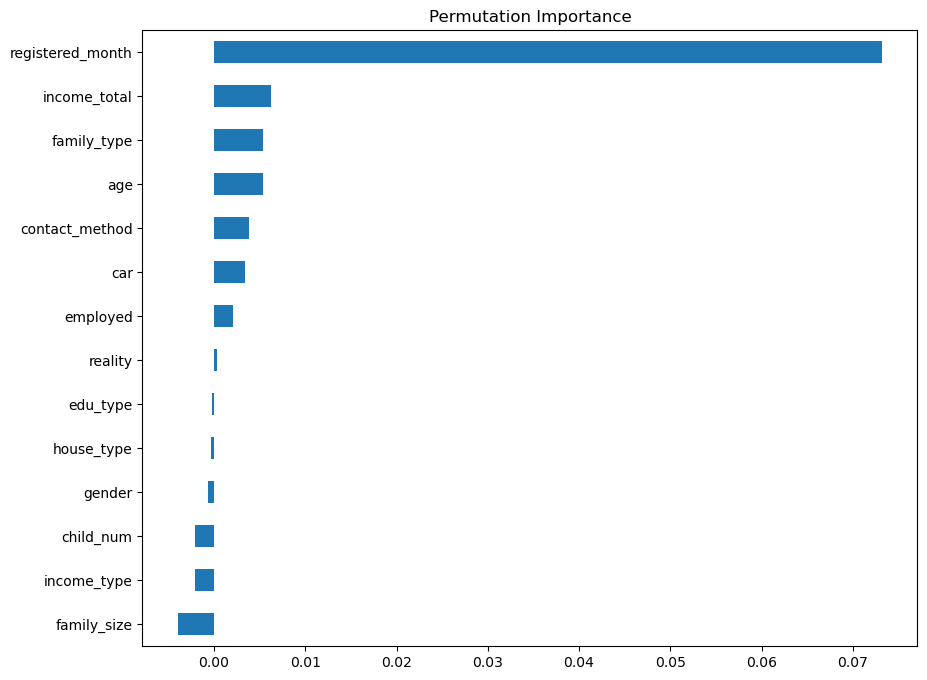

In [100]:
import seaborn as sns

feature_names = x_test_ore.columns.tolist()
pi = pd.Series(permuter.feature_importances_, feature_names).sort_values()


plt.figure(figsize=(10,8))
pi.plot.barh()
plt.title("Permutation Importance")

In [104]:
# Permutation Importance가 음수인 컬럼 삭제

def low_permutation(x):
    low_permu_list = ['edu_type', 'house_type', 'gender', 'child_num', 'income_type', 'family_size']
    x_new = x.drop(columns = low_permu_list)
    
    return x_new

x_train_new = low_permutation(x_train)
x_val_new = low_permutation(x_val)
x_test_new = low_permutation(x_test)

print(f'train data : x{x_train_new.shape}, y{y_train.shape}')
print(f'val data : x{x_val_new.shape}, y{y_val.shape}')
print(f'test data : x{x_test_new.shape}, y{y_test.shape}')

train data : x(16929, 8), y(16929,)
val data : x(4233, 8), y(4233,)
test data : x(5291, 8), y(5291,)


In [106]:
# 컬럼 삭제한 데이터로 학습
model2 = RandomForestClassifier(
    max_depth = 29,
    random_state = 1)

x_train_new_ore = ore.fit_transform(x_train_new)
x_val_new_ore = ore.transform(x_val_new)
x_test_new_ore = ore.transform(x_test_new)

model2.fit(x_train_new_ore, y_train)

# 예측 
y_val_new_pred = model2.predict(x_val_new_ore)

# 평가 및 이전 모델과 비교
model2_eval = pd.DataFrame(index=['Accuracy', 'F1_class0', 'F1_class1', 'F1_class2'], columns=['Model', 'Model2'])
model2_eval['Model'] = eval_models(y_val, y_val_pred)
model2_eval['Model2'] = eval_models(y_val, y_val_new_pred)
model2_eval

# class2 예측력이 좋은 model

,Model,Model2
Accuracy,0.6858,0.6971
F1_class0,0.3506,0.2388
F1_class1,0.5200,0.5009
F1_class2,0.7939,0.8081


In [107]:
# test셋을 통한 평가

y_test_new_pred = model2.predict(x_test_new_ore)

acc, f0, f1, f2 = eval_models(y_test, y_test_new_pred)
print(f"TEST Accuracy : {acc}")
print(f'TEST f1 score : class0 - {f0}, class1 - {f1}, class2 - {f2}')

TEST Accuracy : 0.69003969003969
TEST f1 score : class0 - 0.2507970244420829, class1 - 0.47678916827852996, class2 - 0.8028522382147102


## PDP

(<Figure size 1500x1500 with 7 Axes>,
 {'title_ax': <Axes: >,
  'pdp_ax': [{'_pdp_ax': <Axes: >,
    '_count_ax': <Axes: title={'center': 'distribution of data points'}, xlabel='registered_month (class 0)'>},
   {'_pdp_ax': <Axes: >,
    '_count_ax': <Axes: title={'center': 'distribution of data points'}, xlabel='registered_month (class 1)'>},
   {'_pdp_ax': <Axes: >,
    '_count_ax': <Axes: title={'center': 'distribution of data points'}, xlabel='registered_month (class 2)'>}]})

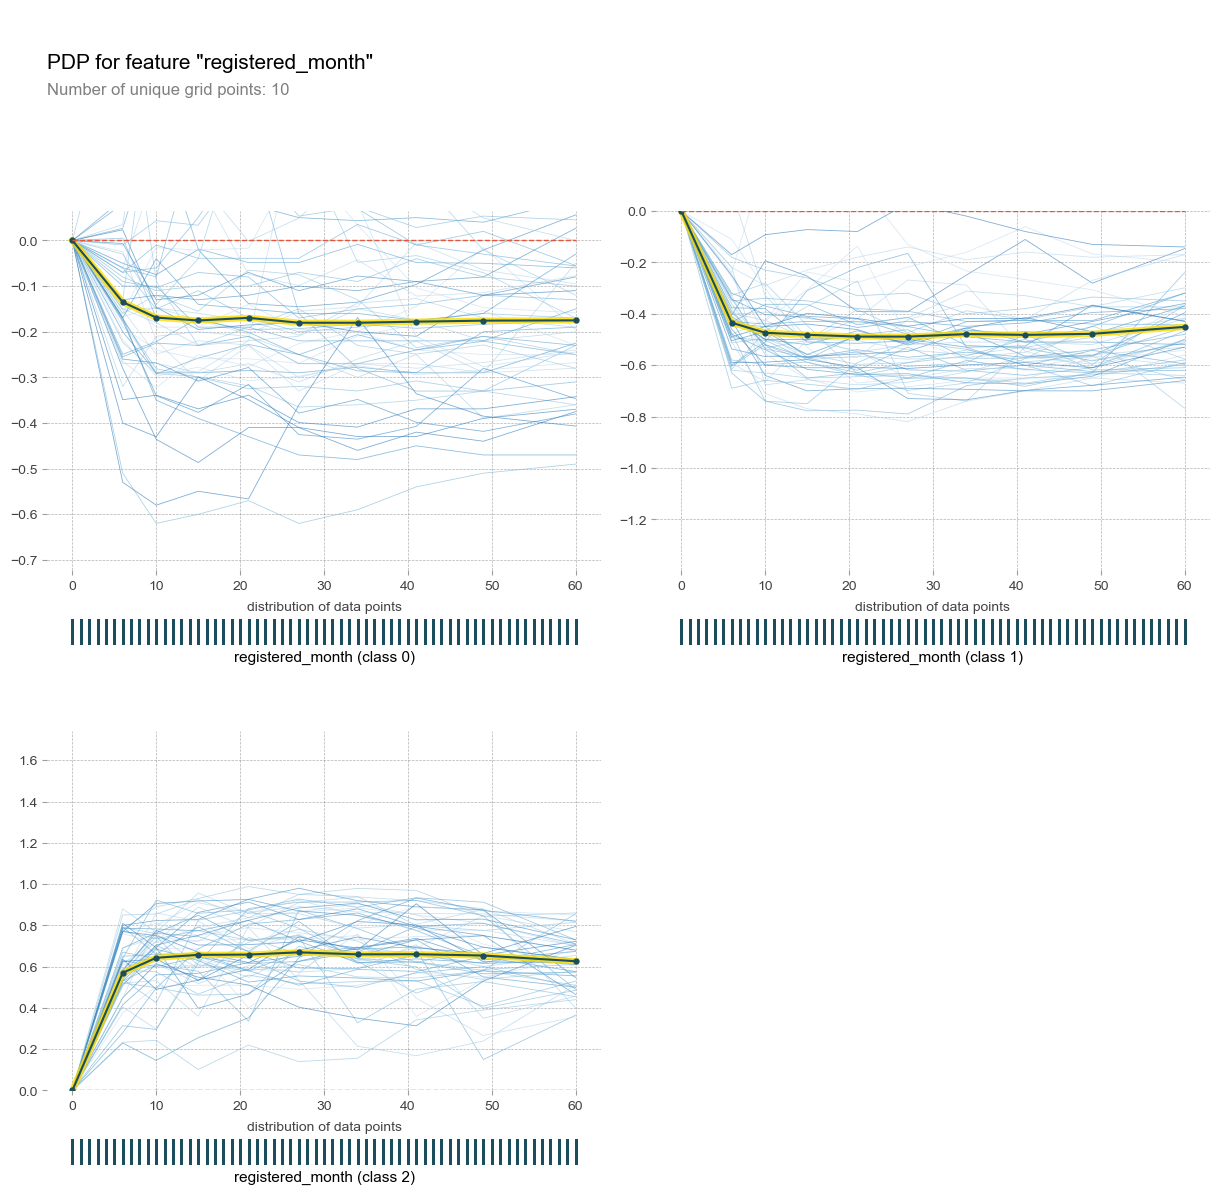

In [111]:
# 등록기간에 따른 신용도 변화

target_feature = 'registered_month'

isolated = pdp_isolate(
    model=model2,
    dataset=x_test_new_ore,
    model_features=x_test_new_ore.columns,
    feature=target_feature,
    grid_type="percentile",
    num_grid_points=10, 
)

pdp_plot(
    isolated,
    feature_name=target_feature,
    plot_lines=True,  # ICE plots
    frac_to_plot=50,  # 전체 데이터 갯수 중 plotting할 데이터 수의 비율
    plot_pts_dist=True,
)

(<Figure size 1500x1500 with 7 Axes>,
 {'title_ax': <Axes: >,
  'pdp_ax': [{'_pdp_ax': <Axes: >,
    '_count_ax': <Axes: title={'center': 'distribution of data points'}, xlabel='family_type (class 0)'>},
   {'_pdp_ax': <Axes: >,
    '_count_ax': <Axes: title={'center': 'distribution of data points'}, xlabel='family_type (class 1)'>},
   {'_pdp_ax': <Axes: >,
    '_count_ax': <Axes: title={'center': 'distribution of data points'}, xlabel='family_type (class 2)'>}]})

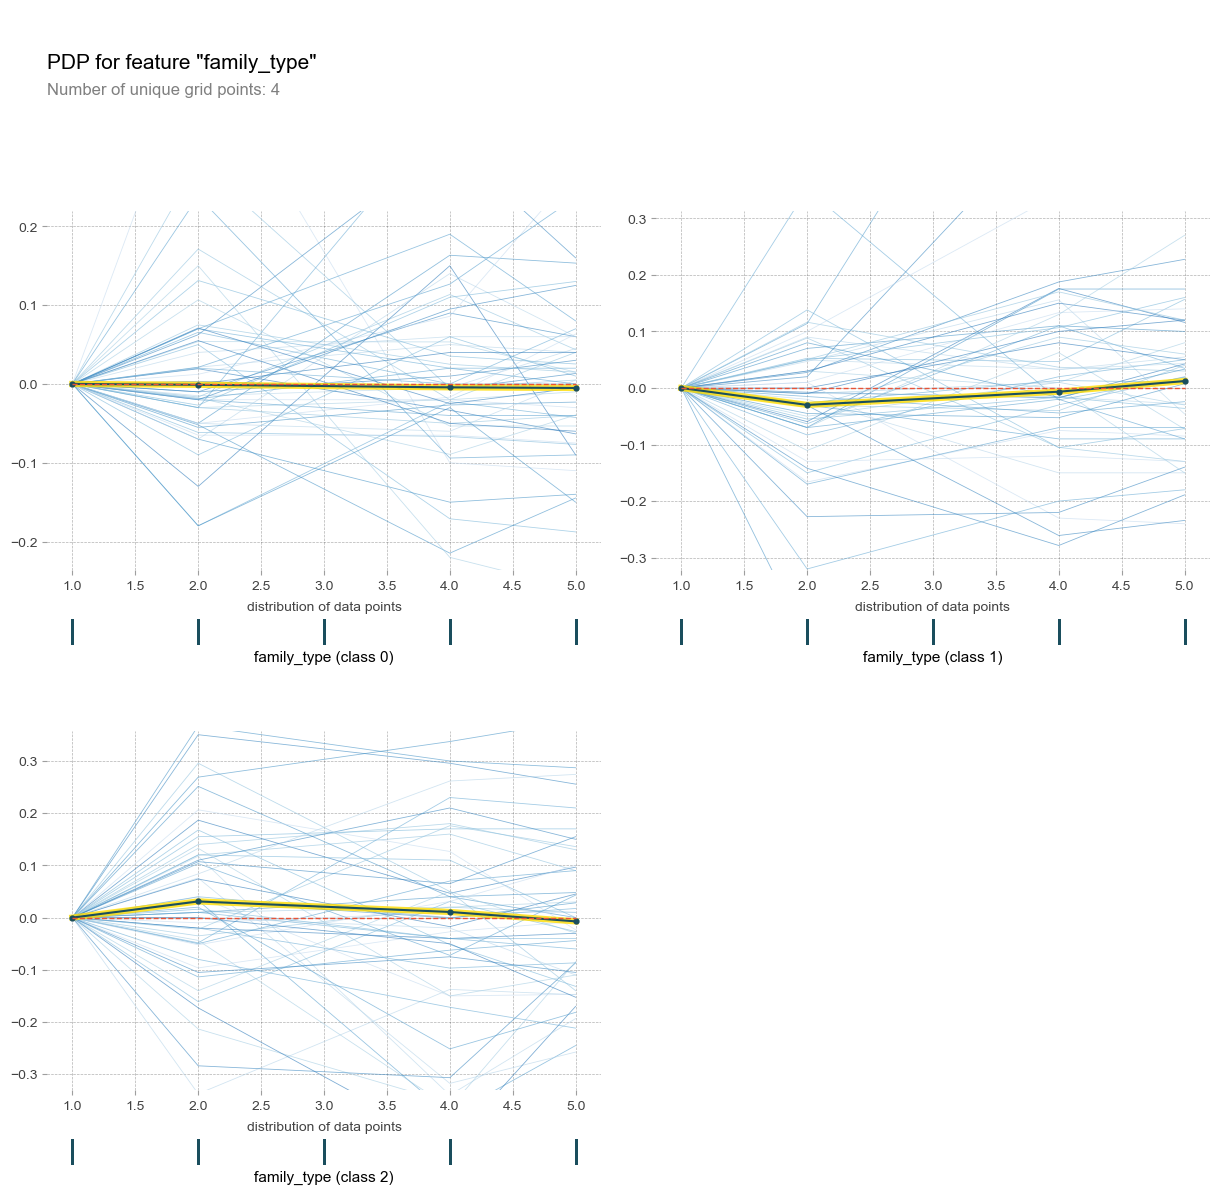

In [113]:
# 가족 구성에 따른 신용도 변화

target_feature = 'family_type'

isolated = pdp_isolate(
    model=model2,
    dataset=x_test_new_ore,
    model_features=x_test_new_ore.columns,
    feature=target_feature,
    grid_type="percentile",
    num_grid_points=10, 
)

pdp_plot(
    isolated,
    feature_name=target_feature,
    plot_lines=True,  # ICE plots
    frac_to_plot=50,  # 전체 데이터 갯수 중 plotting할 데이터 수의 비율
    plot_pts_dist=True,
)

In [114]:
ore.mapping

[{'col': 'family_type',
  'mapping': Civil marriage          1
  Married                 2
  Separated               3
  Single / not married    4
  Widow                   5
  NaN                    -2
  dtype: int64,
  'data_type': dtype('O')}]

(<Figure size 1500x1500 with 7 Axes>,
 {'title_ax': <Axes: >,
  'pdp_ax': [{'_pdp_ax': <Axes: >,
    '_count_ax': <Axes: title={'center': 'distribution of data points'}, xlabel='income_total (class 0)'>},
   {'_pdp_ax': <Axes: >,
    '_count_ax': <Axes: title={'center': 'distribution of data points'}, xlabel='income_total (class 1)'>},
   {'_pdp_ax': <Axes: >,
    '_count_ax': <Axes: title={'center': 'distribution of data points'}, xlabel='income_total (class 2)'>}]})

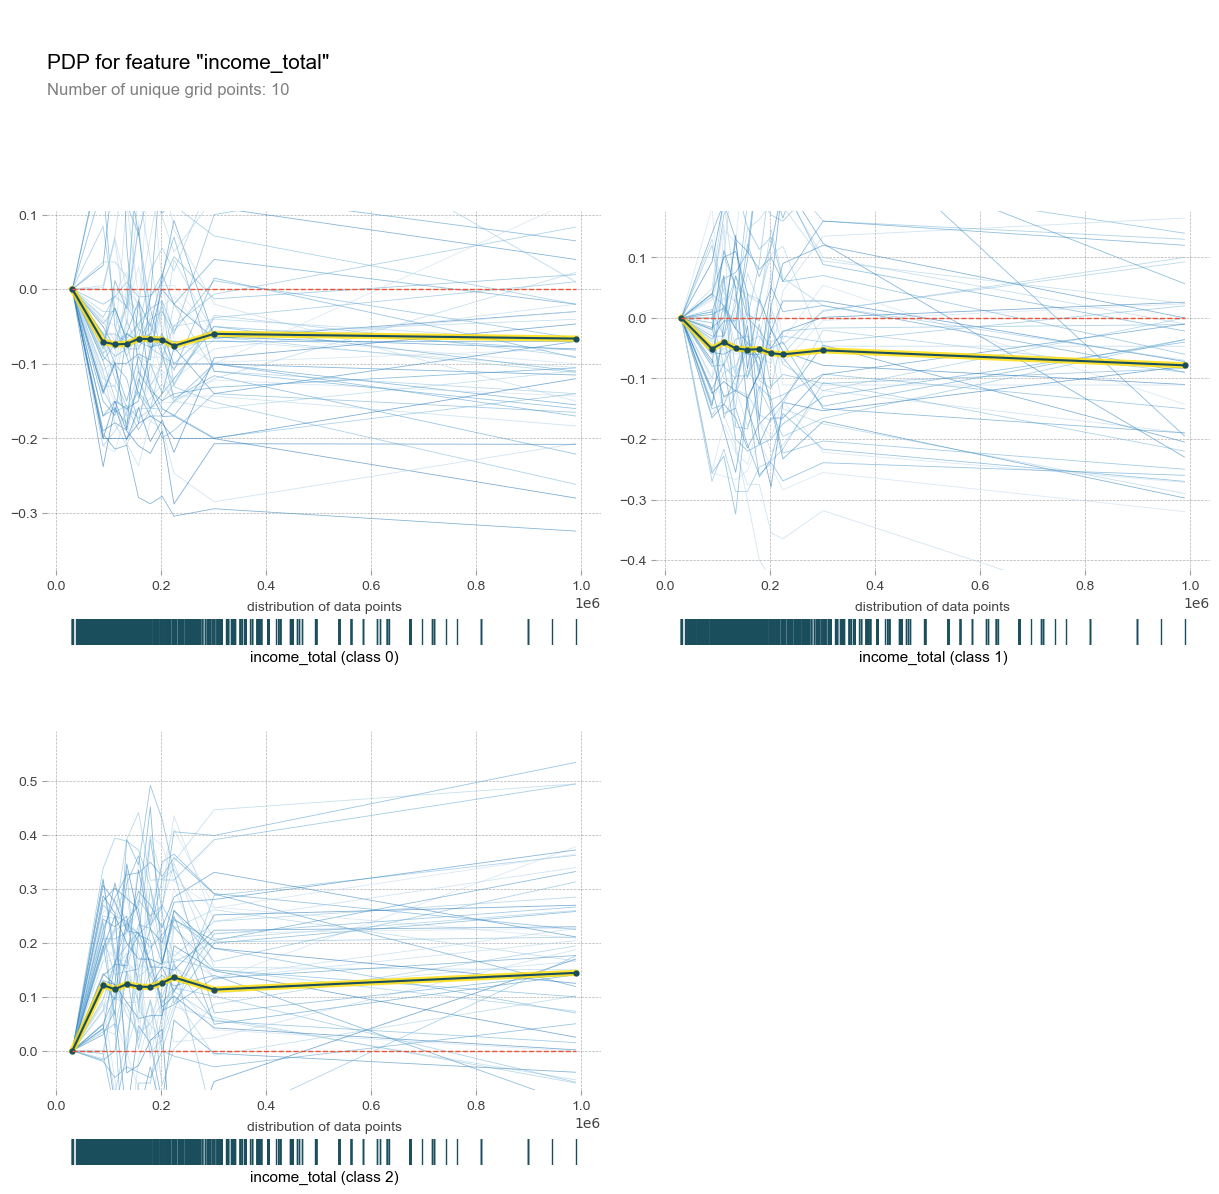

In [115]:
# 수입에 따른 신용도 변화

target_feature = 'income_total'

isolated = pdp_isolate(
    model=model2,
    dataset=x_test_new_ore,
    model_features=x_test_new_ore.columns,
    feature=target_feature,
    grid_type="percentile",
    num_grid_points=10, 
)

pdp_plot(
    isolated,
    feature_name=target_feature,
    plot_lines=True,  # ICE plots
    frac_to_plot=50,  # 전체 데이터 갯수 중 plotting할 데이터 수의 비율
    plot_pts_dist=True,
)

(<Figure size 1500x1500 with 7 Axes>,
 {'title_ax': <Axes: >,
  'pdp_ax': [{'_pdp_ax': <Axes: >,
    '_count_ax': <Axes: title={'center': 'distribution of data points'}, xlabel='age (class 0)'>},
   {'_pdp_ax': <Axes: >,
    '_count_ax': <Axes: title={'center': 'distribution of data points'}, xlabel='age (class 1)'>},
   {'_pdp_ax': <Axes: >,
    '_count_ax': <Axes: title={'center': 'distribution of data points'}, xlabel='age (class 2)'>}]})

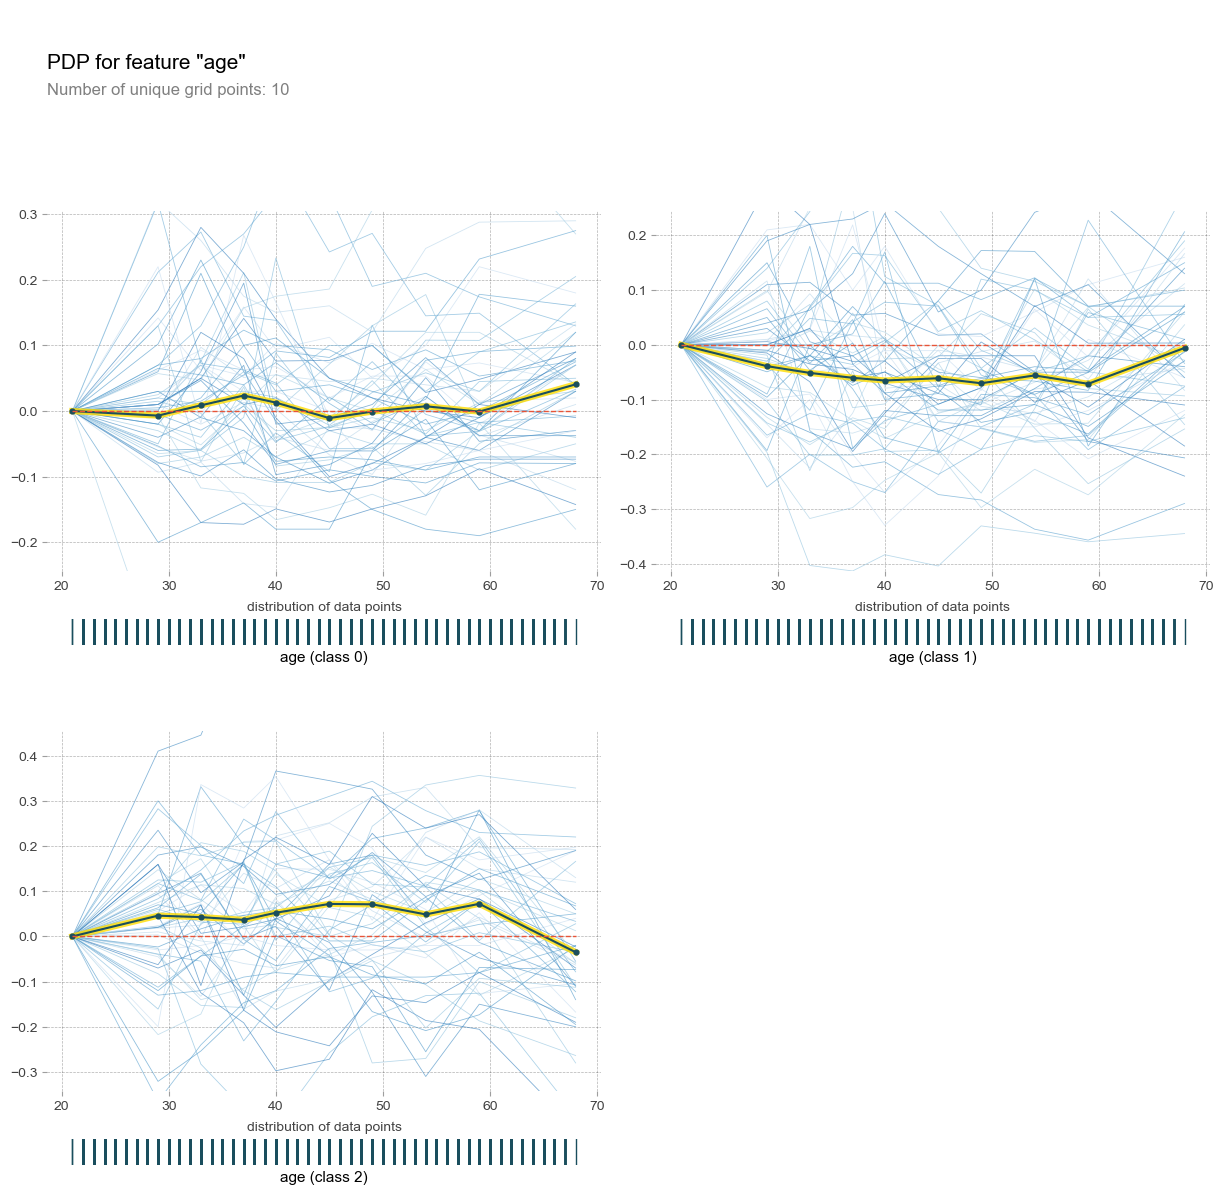

In [112]:
# 나이에 따른 신용도 변화

target_feature = 'age'

isolated = pdp_isolate(
    model=model2,
    dataset=x_test_new_ore,
    model_features=x_test_new_ore.columns,
    feature=target_feature,
    grid_type="percentile",
    num_grid_points=10, 
)

pdp_plot(
    isolated,
    feature_name=target_feature,
    plot_lines=True,  # ICE plots
    frac_to_plot=50,  # 전체 데이터 갯수 중 plotting할 데이터 수의 비율
    plot_pts_dist=True,
)